In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os
temp = '/content/drive/Shareddrives/Annota/NLPAI/Data/Phase2Misc/rq_map.json'
with open(temp, 'r') as infile:
    transcript_rq_lookup = json.load(infile)
final = []
files = os.listdir('/content/drive/Shareddrives/Annota/NLPAI/Data/Phase2Data/')
files.remove('rq_expanded.json')
RQ = 'Strengths, Weaknesses, Uniqueness'

phase1 = ["Edith Stacy",
"Thomas Cao",
"Jane Smith",
"Uma Rose",
"Jay",
"Victor Clayton",
"Guanyu Sun",
"Jaya Power"]

def merge_JsonFiles(filename, res, test=0):
    result = list()
    for f1 in filename:
      if test:
        f1 = '/content/drive/Shareddrives/Annota/Data/annotated_transcripts/' + f1
      else:
        # if the current transcript doesn't have the current RQ
        name = f1.split('.json')
        if RQ not in transcript_rq_lookup[name[0]] or name[0] not in phase1:
          continue
        else:
          print("name: ", name[0])
        f1 = '/content/drive/Shareddrives/Annota/NLPAI/Data/Phase2Data/' + f1
      prev_len = len(result)
      with open(f1, 'r') as infile:
        result.extend(json.load(infile))
        print(len(result) - prev_len)
      with open(res, 'w') as output_file:
        json.dump(result, output_file)
    return result
    
sw_data = merge_JsonFiles(files, 'appended.json')

name:  Jaya Power
306
name:  Jane Smith
82
name:  Thomas Cao
90
name:  Victor Clayton
150
name:  Jay
95
name:  Edith Stacy
309
name:  Uma Rose
100
name:  Guanyu Sun
263


In [ ]:
##We'll only consider the documents that have grades for visualization purposes.

#graded_docs = [sent for sent in sw_data]
graded_docs = [sent for sent in sw_data if "grader_annotations" in sent.keys()]
anns = [ann["id"] for doc in graded_docs for ann in doc["annotations"] if ann["ResearchQuestionId"] == RQ ]
dev_team = set(["ann0_170", "ann0_169", "ann0_141", "ann0_124", "ann0_106", "ann0_95", "ann0_69", "ann0_42"])
anns = sorted(list(set(anns) - dev_team))

len(anns)
len(graded_docs)

681

In [ ]:
grade_map = {"NOT_RELEVANT": 0, "RELEVANT": 1, "UNSURE": 0, "REQUIRED": 2}
grades = [grade_map[doc["grader_annotations"][RQ]] for doc in graded_docs]
binary_grades = [0 if grade <1 else 1 for grade in grades]

In [ ]:
for doc_index in range(len(graded_docs)):
  ## I want to replace each list of annotations by a dictionary, where each key is an annotator id, and the value is the rest of the dict.
  doc = graded_docs[doc_index]
  doc["annotations"] = {ann["id"]:{"ResearchQuestionId": ann["ResearchQuestionId"], "text": ann["text"]} for ann in doc["annotations"]}
  graded_docs[doc_index] = doc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## For each doc in graded_docs, we represent it by a list of annotations from each annotator. If that annotator is present, we take their annotation, otherwise, assume 0.
doc_anns = []

for doc in graded_docs:
  annotation = [1.0 if id in doc["annotations"].keys() else 0.0 for id in anns]
  doc_anns.append(np.array(annotation))

doc_anns = np.array(doc_anns)

In [ ]:
anns

['ann0_10',
 'ann0_101',
 'ann0_110',
 'ann0_112',
 'ann0_121',
 'ann0_14',
 'ann0_142',
 'ann0_143',
 'ann0_15',
 'ann0_166',
 'ann0_171',
 'ann0_173',
 'ann0_175',
 'ann0_176',
 'ann0_194',
 'ann0_196',
 'ann0_199',
 'ann0_203',
 'ann0_204',
 'ann0_212',
 'ann0_213',
 'ann0_223',
 'ann0_228',
 'ann0_231',
 'ann0_234',
 'ann0_31',
 'ann0_33',
 'ann0_50',
 'ann0_54',
 'ann0_75',
 'ann0_85',
 'ann0_86',
 'ann0_92',
 'ann0_97']

Implement the First Step of EM Variant:

In [ ]:
kmed_steps = 1000
em_steps = 1

In [ ]:
true_conf = np.ones((len(anns), 2))

##Accuracy on zeros
##This is going to be the number of ones where they predicted zero correctly / the total number of times they predicted zero 
true_conf[:, 0] = np.matmul(1 - doc_anns.T, 1 - np.array(binary_grades))/np.sum(1 - doc_anns.T, axis = 1)
true_conf[:, 1] = np.matmul(doc_anns.T, np.array(binary_grades))/np.sum(doc_anns.T, axis = 1)

#true_conf /= np.sum(true_conf, axis = 0)

In [ ]:
np.mean(true_conf, axis = 0)

array([0.81980973, 0.41615882])

In [ ]:
import random
## We represent confidence as a single matrix. 
## It has n rows, one for each annotator, and two columns, one for the confidence of predicting 0, another for the confidence of predicting 1.
## We initialize our confidence in the predictions of all annotators of 0 or 1 at 1.

confidence = np.ones((len(anns), 2)) 

## Count is accumulated repeatedly. This is an Expectation Step.
## This is a normalized weighted vote.

for em_step in range(em_steps):

  print("Iteration", em_step,":")

  count = len(anns) * (np.matmul(doc_anns, confidence[:, 1]*confidence[:, 1]) / (np.matmul(doc_anns, confidence[:, 1]*confidence[:, 1]) + np.matmul(1 - doc_anns, confidence[:, 0]*confidence[:, 0])))

  ## Now, we cluster
  centroids = random.choices(list(set(count)), k = 3)

  alloc = [0 for i in range(len(count))]

  groups = dict()

  for i in range(kmed_steps):

    centroids = sorted(centroids)
    ##Pick the ideal allocation by centroids
    ##alloc should be the elements of centroids that each element of count is closest to.
    
    for c in range(len(count)):

      alloc[c] = np.argmin([np.abs(count[c] - centroid) for centroid in centroids])

    ##Pick the ideal centroids, will be the median of the counts per allocs.

    for centroid_index in range(len(centroids)): #(For each centroid, collect all its assignees, then compute their median as the centroid)
      assignees = np.where(np.array(alloc) == centroid_index)[0]
      #assert len(assignees) != 0, (centroids, centroid_index, alloc)
      centroids[centroid_index] = np.median(np.array([count[assignee] for assignee in assignees]))
      groups[centroid_index] =  assignees

  ##Maximization Step:

  lum = set(groups[0]) | set(groups[1])
  muh = set(groups[1]) | set(groups[2])
  assert len(lum) + len(muh) >= len(graded_docs)
  confidence[:, 0] = np.sum(1 - np.array([doc_anns[j, :] for j in lum]), axis = 0)/np.sum(1 - doc_anns, axis = 0)
  confidence[:, 1] = np.sum(np.array([doc_anns[j, :] for j in muh]), axis = 0)/np.sum(doc_anns, axis = 0)
#  confidence[:, 0]/=np.sum(confidence[:, 0])
#  confidence[:, 1]/=np.sum(confidence[:, 1])

  
  low = [i for i in range(len(graded_docs)) if grades[i] == 0]
  hi = [i for i in range(len(graded_docs)) if grades[i] == 2]
  mid = [i for i in range(len(graded_docs)) if grades[i] == 1]
  low_counts = [count[i] for i in low]
  mid_counts = [count[i] for i in mid]
  hi_counts = [count[i] for i in hi]
  cluster_bounds = [(centroids[0] + centroids[1])/2, (centroids[1] + centroids[2])/2]
  print("Centroids: ", centroids)
  print("Cluster Boundaries: ", cluster_bounds)
  plt.figure()
  plt.hlines(1, 1, 100)  # Draw a horizontal line
  plt.eventplot(low_counts, orientation='horizontal', colors='b')
  plt.eventplot(cluster_bounds, orientation = 'horizontal', colors = 'black', linelengths = 2)
  plt.axis('off')
  plt.show()
  plt.figure()
  plt.hlines(1, 1, 100)  # Draw a horizontal line
  plt.eventplot(mid_counts, orientation='horizontal', colors='g')
  plt.eventplot(cluster_bounds, orientation = 'horizontal', colors = 'black', linelengths = 2)
  plt.axis('off')
  plt.show()
  plt.figure()
  plt.hlines(1, 0, 100)  # Draw a horizontal line
  plt.eventplot(hi_counts, orientation='horizontal', colors='r')
  plt.eventplot(cluster_bounds, orientation = 'horizontal', colors = 'black', linelengths = 2)
  plt.axis('off')
  plt.show()

for c in range(len(count)):
    alloc[c] = centroids[alloc[c]]

Iteration 0 :


KeyboardInterrupt: ignored

[[1.         0.80384965]
 [0.80384965 1.        ]]


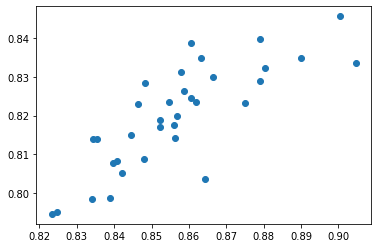

In [ ]:
print(np.corrcoef(confidence[:, 0], true_conf[:, 0]))
plt.scatter(confidence[:, 0], true_conf[:, 0])

[[1.        0.7918248]
 [0.7918248 1.       ]]


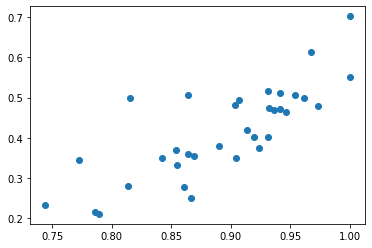

In [ ]:
print(np.corrcoef(confidence[:, 1], true_conf[:, 1]))
plt.scatter(confidence[:, 1], true_conf[:, 1])

In [ ]:
import matplotlib.cm as cm
import matplotlib.animation as animation

In [ ]:
em_steps = 1

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


<Figure size 432x288 with 0 Axes>

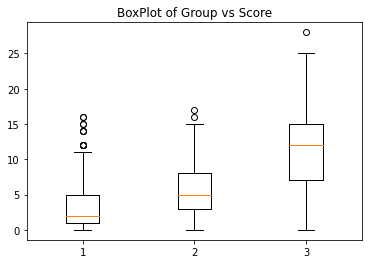

In [ ]:
import random
## We represent confidence as a single matrix. 
## It has n rows, one for each annotator, and two columns, one for the confidence of predicting 0, another for the confidence of predicting 1.
## We initialize our confidence in the predictions of all annotators of 0 or 1 at 1.

confidence = np.ones((len(anns), 2)) 

## Count is accumulated repeatedly. This is an Expectation Step.
## This is a normalized weighted vote.
plt.figure()

frames = []

for em_step in range(em_steps):

  count = len(anns) * (np.matmul(doc_anns, confidence[:, 1] * confidence[:, 1]) / (np.matmul(doc_anns, confidence[:, 1] * confidence[:, 1]) + np.matmul(1 - doc_anns, confidence[:, 0] * confidence[:, 0])))

  ## Now, we cluster
  centroids = random.choices(count, k = 3)

  alloc = [0 for i in range(len(count))]

  groups = dict()

  for i in range(kmed_steps):

    centroids = sorted(centroids)

    ##Pick the ideal allocation by centroids
    ##alloc should be the elements of centroids that each element of count is closest to.
    
    for c in range(len(count)):

      alloc[c] = np.argmin([np.abs(count[c] - centroid) for centroid in centroids])

    ##Pick the ideal centroids, will be the median of the counts per allocs.

    for centroid_index in range(len(centroids)): #(For each centroid, collect all its assignees, then compute their median as the centroid)
      assignees = np.where(np.array(alloc) == centroid_index)[0]
      centroids[centroid_index] = np.median(np.array([count[assignee] for assignee in assignees]))
      groups[centroid_index] =  assignees

  ##Maximization Step:

  lum = set(groups[0]) | set(groups[1])
  muh = set(groups[1]) | set(groups[2])
  assert len(lum) + len(muh) >= len(graded_docs)
  confidence[:, 0] = np.sum(1 - np.array([doc_anns[j, :] for j in lum]), axis = 0)/np.sum(1 - doc_anns, axis = 0)
  confidence[:, 1] = np.sum(np.array([doc_anns[j, :] for j in muh]), axis = 0)/np.sum(doc_anns, axis = 0)
  confidence[:, 0]/=np.sum(confidence[:, 0])
  confidence[:, 1]/=np.sum(confidence[:, 1])

  low = [i for i in range(len(graded_docs)) if grades[i] == 0]
  hi = [i for i in range(len(graded_docs)) if grades[i] == 2]
  mid = [i for i in range(len(graded_docs)) if grades[i] == 1]
  #plt.hlines(1, 1, 100)  # Draw a horizontal line

  low_counts = [count[i] for i in low]
  mid_counts = [count[i] for i in mid]
  hi_counts = [count[i] for i in hi]
  fig1, ax1 = plt.subplots()
  ax1.set_title('BoxPlot of Group vs Score')
  ax1.boxplot(np.array([low_counts, mid_counts, hi_counts]).T)
  #plt.eventplot(low_counts, orientation='horizontal', colors='b')
  #plt.eventplot(mid_counts, orientation='horizontal', colors='g')
  #plt.eventplot(hi_counts, orientation='horizontal', colors='r')
  
  plt.show()

for c in range(len(count)):
  alloc[c] = centroids[alloc[c]]

What if we used true confidence?


Truly NOT RELEVANT:
Predicted NOT RELEVANT:  372 , Percent:  68.76155268022181
Predicted RELEVANT:  148 , Percent:  27.35674676524954
Predicted REQUIRED:  21 , Percent:  3.8817005545286505
Total number of truly NOT RELEVANT:  541

Truly RELEVANT:
Predicted NOT RELEVANT:  33 , Percent:  32.03883495145631
Predicted RELEVANT:  43 , Percent:  41.74757281553398
Predicted REQUIRED:  27 , Percent:  26.21359223300971
Total number of truly RELEVANT:  103

Truly REQUIRED:
Predicted NOT RELEVANT:  5 , Percent:  13.513513513513514
Predicted RELEVANT:  7 , Percent:  18.91891891891892
Predicted REQUIRED:  25 , Percent:  67.56756756756756
Total number of truly REQUIRED:  37
Macro F1:  0.8377019405410573
True Macro F1 (Middle-Centroid):  0.6535464535464535
True Macro F1 (Average-Centroid):  0.756821733381416


<Figure size 432x288 with 0 Axes>

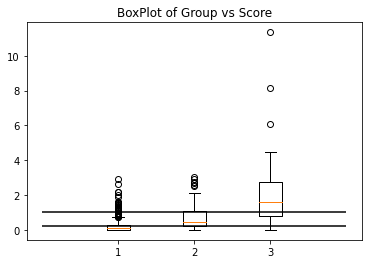

In [ ]:
import random
## We represent confidence as a single matrix. 
## It has n rows, one for each annotator, and two columns, one for the confidence of predicting 0, another for the confidence of predicting 1.
## We initialize our confidence in the predictions of all annotators of 0 or 1 at 1.

confidence = true_conf

## Count is accumulated repeatedly. This is an Expectation Step.
## This is a normalized weighted vote.
plt.figure()

frames = []
power = 4
for em_step in range(1):

  count = len(anns) * (np.matmul(doc_anns, np.power(confidence[:, 1], power)) / (np.matmul(doc_anns, np.power(confidence[:, 1], power)) + np.matmul(1 - doc_anns, np.power(confidence[:, 0], power))))

  ## Now, we cluster
  centroids = random.sample(list(set(count)), 3)

  alloc = [0 for i in range(len(count))]

  groups = dict()

  for i in range(kmed_steps):

    centroids = sorted(centroids)

    ##Pick the ideal allocation by centroids
    ##alloc should be the elements of centroids that each element of count is closest to.
    
    for c in range(len(count)):

      alloc[c] = np.argmin([np.abs(count[c] - centroid) for centroid in centroids])

    ##Pick the ideal centroids, will be the median of the counts per allocs.

    for centroid_index in range(len(centroids)): #(For each centroid, collect all its assignees, then compute their median as the centroid)
      assignees = np.where(np.array(alloc) == centroid_index)[0]
      centroids[centroid_index] = np.median(np.array([count[assignee] for assignee in assignees]))
      groups[centroid_index] =  list(assignees)

  ##Maximization Step:

  lum = set(groups[0]) | set(groups[1])
  muh = set(groups[1]) | set(groups[2])
  assert len(lum) + len(muh) >= len(graded_docs)

  low = [i for i in range(len(graded_docs)) if grades[i] == 0]
  hi = [i for i in range(len(graded_docs)) if grades[i] == 2]
  mid = [i for i in range(len(graded_docs)) if grades[i] == 1]
  centroid_boundaries = [(centroids[0] + centroids[1])/2, (centroids[1] + centroids[2])/2]
  
  low_counts = [count[i] for i in low]
  mid_counts = [count[i] for i in mid]
  hi_counts = [count[i] for i in hi]
  
  fig1, ax1 = plt.subplots()
  ax1.set_title('BoxPlot of Group vs Score')
  ax1.boxplot(np.array([low_counts, mid_counts, hi_counts], dtype = object).T)
  ax1.hlines(centroid_boundaries[0], 0, 4)  # Draw a horizontal line
  ax1.hlines(centroid_boundaries[1], 0, 4)  # Draw a horizontal line

  ##For all docs,  if it's non-rel, take NON-RELEVANT and RELEVANT as correct.
  ##For all docs, if it's req, take RELEVANT AND REQUIRED as correct.

  print("\nTruly NOT RELEVANT:")
  not_rel_zero = len([1 for count_index in low if count_index in groups[0]])
  not_rel_one = len([1 for count_index in low if count_index in groups[1]])
  not_rel_two = len([1 for count_index in low if count_index in groups[2]])
  not_rel = len(low)
  print("Predicted NOT RELEVANT: ", not_rel_zero, ", Percent: ", 100 * not_rel_zero/not_rel)
  print("Predicted RELEVANT: ", not_rel_one, ", Percent: ", 100 * not_rel_one/not_rel)
  print("Predicted REQUIRED: ", not_rel_two, ", Percent: ", 100 * not_rel_two/not_rel)
  print("Total number of truly NOT RELEVANT: ", not_rel)

  print("\nTruly RELEVANT:")
  rel_zero = len([1 for count_index in mid if count_index in groups[0]])
  rel_one = len([1 for count_index in mid if count_index in groups[1]])
  rel_two = len([1 for count_index in mid if count_index in groups[2]])
  rel = len(mid)
  print("Predicted NOT RELEVANT: ", rel_zero, ", Percent: ", 100 * rel_zero/rel)
  print("Predicted RELEVANT: ", rel_one, ", Percent: ", 100 * rel_one/rel)
  print("Predicted REQUIRED: ", rel_two, ", Percent: ", 100 * rel_two/rel)
  print("Total number of truly RELEVANT: ", rel)

  print("\nTruly REQUIRED:")
  req_zero = len([1 for count_index in hi if count_index in groups[0]])
  req_one = len([1 for count_index in hi if count_index in groups[1]])
  req_two = len([1 for count_index in hi if count_index in groups[2]])
  req = len(hi)
  print("Predicted NOT RELEVANT: ", req_zero, ", Percent: ", 100 * req_zero/req)
  print("Predicted RELEVANT: ", req_one, ", Percent: ", 100 * req_one/req)
  print("Predicted REQUIRED: ", req_two, ", Percent: ", 100 * req_two/req)
  print("Total number of truly REQUIRED: ", req)
  
  try:
    non_rel_prec = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(groups[0])
    ##Recall: TP/(TP + FN)
    non_rel_recall = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(low)
    non_rel_f1 = (2 * non_rel_prec * non_rel_recall)/(non_rel_prec + non_rel_recall)

    ##Class Required:
    ##Precision: TP/(TP + FP)
    req_prec = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(groups[2])
    ##Recall: TP/(TP + FN)
    req_recall = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(hi)
    req_f1 = (2 * req_prec * req_recall)/(req_prec + req_recall)
    print("Macro F1: ", (req_f1 + non_rel_f1)/2)
    predicted_grades = []
    predicted_grades_2 = []
    for i in range(len(count)):
      icount = count[i]
      mid_centroid = centroids[1]
      avg_centroid = (centroids[0] + centroids[2])/2
      if(icount <= mid_centroid):
        predicted_grades.append(0)
      elif(icount > mid_centroid):
        predicted_grades.append(1)
      if(icount <= avg_centroid):
        predicted_grades_2.append(0)
      elif(icount > avg_centroid):
        predicted_grades_2.append(1)

    grades = np.array(grades)
    test = grades != 1
    pred_grad = np.array(predicted_grades)
    pred_grad_2 = np.array(predicted_grades_2)
    bin_grad = grades.copy()
    bin_grad[grades >= 1] = 1 
    print("True Macro F1 (Middle-Centroid): ", f1_score(bin_grad[test], pred_grad[test], average = "macro"))
    print("True Macro F1 (Average-Centroid): ", f1_score(bin_grad[test], pred_grad_2[test], average = "macro"))
    plt.show()

  except:
    print("Some group was empty")

for c in range(len(count)):
  alloc[c] = centroids[alloc[c]]

What if we tried higher powers of confidence?

In [ ]:
em_steps = 2
kmed_steps = 1000

Centroids:  [1.0, 6.0, 14.0]
Centroid Boundaries:  [3.5, 10.0]

Truly NOT RELEVANT:
Predicted NOT RELEVANT:  357 , Percent:  65.98890942698706
Predicted RELEVANT:  167 , Percent:  30.868761552680223
Predicted REQUIRED:  17 , Percent:  3.142329020332717
Total number of truly NOT RELEVANT:  541

Truly RELEVANT:
Predicted NOT RELEVANT:  31 , Percent:  30.097087378640776
Predicted RELEVANT:  55 , Percent:  53.398058252427184
Predicted REQUIRED:  17 , Percent:  16.50485436893204
Total number of truly RELEVANT:  103

Truly REQUIRED:
Predicted NOT RELEVANT:  4 , Percent:  10.81081081081081
Predicted RELEVANT:  13 , Percent:  35.13513513513514
Predicted REQUIRED:  20 , Percent:  54.054054054054056
Total number of truly REQUIRED:  37
Macro F1:  0.9242665159063873
True Macro F1 (Middle-Centroid):  0.6928607151787947
True Macro F1 (Average-Centroid):  0.7328802501019437


<Figure size 432x288 with 0 Axes>

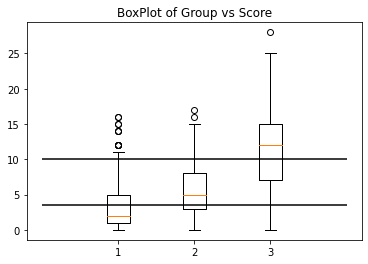

Centroids:  [0.590636895626712, 3.5228061886226794, 9.835181592507935]
Centroid Boundaries:  [2.056721542124696, 6.678993890565307]

Truly NOT RELEVANT:
Predicted NOT RELEVANT:  376 , Percent:  69.50092421441775
Predicted RELEVANT:  147 , Percent:  27.171903881700555
Predicted REQUIRED:  18 , Percent:  3.3271719038817005
Total number of truly NOT RELEVANT:  541

Truly RELEVANT:
Predicted NOT RELEVANT:  34 , Percent:  33.00970873786408
Predicted RELEVANT:  49 , Percent:  47.57281553398058
Predicted REQUIRED:  20 , Percent:  19.41747572815534
Total number of truly RELEVANT:  103

Truly REQUIRED:
Predicted NOT RELEVANT:  5 , Percent:  13.513513513513514
Predicted RELEVANT:  11 , Percent:  29.72972972972973
Predicted REQUIRED:  21 , Percent:  56.75675675675676
Total number of truly REQUIRED:  37
Macro F1:  0.8804044630404464
True Macro F1 (Middle-Centroid):  0.6629290921139827
True Macro F1 (Average-Centroid):  0.756821733381416


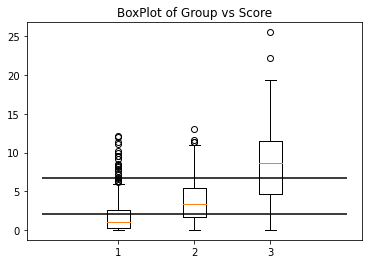

In [ ]:
import random
from sklearn.metrics import f1_score
## We represent confidence as a single matrix. 
## It has n rows, one for each annotator, and two columns, one for the confidence of predicting 0, another for the confidence of predicting 1.
## We initialize our confidence in the predictions of all annotators of 0 or 1 at 1.

confidence = np.ones((len(anns), 2)) 

## Count is accumulated repeatedly. This is an Expectation Step.
## This is a normalized weighted vote.
plt.figure()

frames = []
power = 4
for em_step in range(em_steps):

  count = len(anns) * (np.matmul(doc_anns, np.power(confidence[:, 1],power)) / (np.matmul(doc_anns, np.power(confidence[:, 1], power)) + np.matmul(1 - doc_anns, np.power(confidence[:, 0], power))))

  ## Now, we cluster
  centroids = random.sample(list(set(count)), 3)

  alloc = [0 for i in range(len(count))]

  groups = dict()

  for i in range(kmed_steps):

    centroids = sorted(centroids)

    ##Pick the ideal allocation by centroids
    ##alloc should be the elements of centroids that each element of count is closest to.
    
    for c in range(len(count)):

      alloc[c] = np.argmin([np.abs(count[c] - centroid) for centroid in centroids])

    ##Pick the ideal centroids, will be the median of the counts per allocs.

    for centroid_index in range(len(centroids)): #(For each centroid, collect all its assignees, then compute their median as the centroid)
      assignees = np.where(np.array(alloc) == centroid_index)[0]
      centroids[centroid_index] = np.median(np.array([count[assignee] for assignee in assignees]))
      groups[centroid_index] =  list(assignees)

  ##Maximization Step:

  lum = set(groups[0]) | set(groups[1])
  muh = set(groups[1]) | set(groups[2])
  assert len(lum) + len(muh) >= len(graded_docs)
  confidence[:, 0] = np.sum(1 - np.array([doc_anns[j, :] for j in lum]), axis = 0)/np.sum(1 - doc_anns, axis = 0)
  confidence[:, 1] = np.sum(np.array([doc_anns[j, :] for j in muh]), axis = 0)/np.sum(doc_anns, axis = 0)

  low = [i for i in range(len(graded_docs)) if grades[i] == 0]
  hi = [i for i in range(len(graded_docs)) if grades[i] == 2]
  mid = [i for i in range(len(graded_docs)) if grades[i] == 1]
  #plt.hlines(1, 1, 100)  # Draw a horizontal line

  low_counts = [count[i] for i in low]
  mid_counts = [count[i] for i in mid]
  hi_counts = [count[i] for i in hi]

  centroid_boundaries = [(centroids[0] + centroids[1])/2, (centroids[1] + centroids[2])/2]

  fig1, ax1 = plt.subplots()
  ax1.set_title('BoxPlot of Group vs Score')
  print("Centroids: ", centroids)
  print("Centroid Boundaries: ", centroid_boundaries)
  ax1.boxplot(np.array([low_counts, mid_counts, hi_counts], dtype = object).T)
  
  ax1.hlines(centroid_boundaries[0], 0, 4)  # Draw a horizontal line
  ax1.hlines(centroid_boundaries[1], 0, 4)  # Draw a horizontal line

  print("\nTruly NOT RELEVANT:")
  not_rel_zero = len([1 for count_index in low if count_index in groups[0]])
  not_rel_one = len([1 for count_index in low if count_index in groups[1]])
  not_rel_two = len([1 for count_index in low if count_index in groups[2]])
  not_rel = len(low)
  print("Predicted NOT RELEVANT: ", not_rel_zero, ", Percent: ", 100 * not_rel_zero/not_rel)
  print("Predicted RELEVANT: ", not_rel_one, ", Percent: ", 100 * not_rel_one/not_rel)
  print("Predicted REQUIRED: ", not_rel_two, ", Percent: ", 100 * not_rel_two/not_rel)
  print("Total number of truly NOT RELEVANT: ", not_rel)

  print("\nTruly RELEVANT:")
  rel_zero = len([1 for count_index in mid if count_index in groups[0]])
  rel_one = len([1 for count_index in mid if count_index in groups[1]])
  rel_two = len([1 for count_index in mid if count_index in groups[2]])
  rel = len(mid)
  print("Predicted NOT RELEVANT: ", rel_zero, ", Percent: ", 100 * rel_zero/rel)
  print("Predicted RELEVANT: ", rel_one, ", Percent: ", 100 * rel_one/rel)
  print("Predicted REQUIRED: ", rel_two, ", Percent: ", 100 * rel_two/rel)
  print("Total number of truly RELEVANT: ", rel)

  print("\nTruly REQUIRED:")
  req_zero = len([1 for count_index in hi if count_index in groups[0]])
  req_one = len([1 for count_index in hi if count_index in groups[1]])
  req_two = len([1 for count_index in hi if count_index in groups[2]])
  req = len(hi)
  print("Predicted NOT RELEVANT: ", req_zero, ", Percent: ", 100 * req_zero/req)
  print("Predicted RELEVANT: ", req_one, ", Percent: ", 100 * req_one/req)
  print("Predicted REQUIRED: ", req_two, ", Percent: ", 100 * req_two/req)
  print("Total number of truly REQUIRED: ", req)
  
  ##Class Non-Relevant:
  ##Precision: TP/(TP + FP)
  try:
    non_rel_prec = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(groups[0])
    ##Recall: TP/(TP + FN)
    non_rel_recall = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(low)
    non_rel_f1 = (2 * non_rel_prec * non_rel_recall)/(non_rel_prec + non_rel_recall)

    ##Class Required:
    ##Precision: TP/(TP + FP)
    req_prec = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(groups[2])
    ##Recall: TP/(TP + FN)
    req_recall = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(hi)
    req_f1 = (2 * req_prec * req_recall)/(req_prec + req_recall)
    print("Macro F1: ", (req_f1 + non_rel_f1)/2)
    predicted_grades = []
    predicted_grades_2 = []
    for i in range(len(count)):
      icount = count[i]
      mid_centroid = centroids[1]
      avg_centroid = (centroids[0] + centroids[2])/2
      if(icount <= mid_centroid):
        predicted_grades.append(0)
      elif(icount > mid_centroid):
        predicted_grades.append(1)
      if(icount <= avg_centroid):
        predicted_grades_2.append(0)
      elif(icount > avg_centroid):
        predicted_grades_2.append(1)

    grades = np.array(grades)
    test = grades != 1
    pred_grad = np.array(predicted_grades)
    pred_grad_2 = np.array(predicted_grades_2)
    bin_grad = grades.copy()
    bin_grad[grades >= 1] = 1 
    print("True Macro F1 (Middle-Centroid): ", f1_score(bin_grad[test], pred_grad[test], average = "macro"))
    print("True Macro F1 (Average-Centroid): ", f1_score(bin_grad[test], pred_grad_2[test], average = "macro"))
    plt.show()

  except:
    print("Some group was empty")

for c in range(len(count)):
  alloc[c] = centroids[alloc[c]]

In [ ]:
np.sum(pred_grad_2)

85

In [ ]:
with open("/content/drive/Shareddrives/Annota/NLPAI/Data/Phase2Misc/graded_em_labels.txt", "w") as f:
  f.write(str(pred_grad_2[0]))
  for p in pred_grad_2[1:]:
    f.write(", " + str(p))

[[1.         0.82743154]
 [0.82743154 1.        ]]


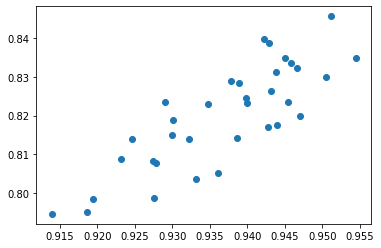

[[1.        0.7484979]
 [0.7484979 1.       ]]


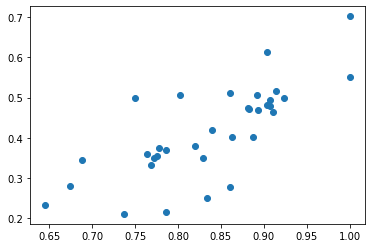

In [ ]:
print(np.corrcoef(confidence[:, 0], true_conf[:, 0]))
plt.figure()
plt.scatter(confidence[:, 0], true_conf[:, 0])
plt.show()
plt.figure()
print(np.corrcoef(confidence[:, 1], true_conf[:, 1]))
plt.scatter(confidence[:, 1], true_conf[:, 1])
plt.show()

What if we used a threshold? If confidence > 0.5, leave it, else drop to 0. confidence = confidence * (confidence > 0.5)

In [ ]:
em_steps = 2

Init Centroids:  [10.0, 1.0, 18.0]
Centroids:  [1.0, 6.0, 14.0]
Centroid Boundaries:  [3.5, 10.0]

Truly NOT RELEVANT:
Predicted NOT RELEVANT:  357 , Percent:  65.98890942698706
Predicted RELEVANT:  167 , Percent:  30.868761552680223
Predicted REQUIRED:  17 , Percent:  3.142329020332717
Total number of truly NOT RELEVANT:  541

Truly RELEVANT:
Predicted NOT RELEVANT:  31 , Percent:  30.097087378640776
Predicted RELEVANT:  55 , Percent:  53.398058252427184
Predicted REQUIRED:  17 , Percent:  16.50485436893204
Total number of truly RELEVANT:  103

Truly REQUIRED:
Predicted NOT RELEVANT:  4 , Percent:  10.81081081081081
Predicted RELEVANT:  13 , Percent:  35.13513513513514
Predicted REQUIRED:  20 , Percent:  54.054054054054056
Total number of truly REQUIRED:  37
Macro F1:  0.9242665159063873
True Macro F1 (Middle-Centroid):  0.6928607151787947
True Macro F1 (Average-Centroid):  0.7328802501019437


<Figure size 432x288 with 0 Axes>

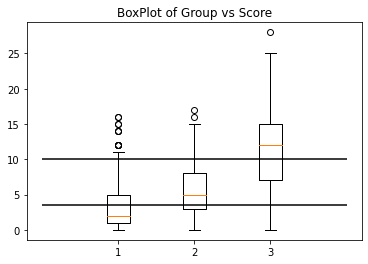

Init Centroids:  [4.123173975045005, 6.987551095558052, 4.27759348370393]
Centroids:  [0.8578674702271064, 4.591659696095983, 12.05182055352665]
Centroid Boundaries:  [2.7247635831615447, 8.321740124811317]

Truly NOT RELEVANT:
Predicted NOT RELEVANT:  356 , Percent:  65.80406654343808
Predicted RELEVANT:  165 , Percent:  30.499075785582257
Predicted REQUIRED:  20 , Percent:  3.6968576709796674
Total number of truly NOT RELEVANT:  541

Truly RELEVANT:
Predicted NOT RELEVANT:  30 , Percent:  29.12621359223301
Predicted RELEVANT:  52 , Percent:  50.48543689320388
Predicted REQUIRED:  21 , Percent:  20.388349514563107
Total number of truly RELEVANT:  103

Truly REQUIRED:
Predicted NOT RELEVANT:  4 , Percent:  10.81081081081081
Predicted RELEVANT:  10 , Percent:  27.027027027027028
Predicted REQUIRED:  23 , Percent:  62.16216216216216
Total number of truly REQUIRED:  37
Macro F1:  0.8863459922791419
True Macro F1 (Middle-Centroid):  0.6393280571361494
True Macro F1 (Average-Centroid):  0.7

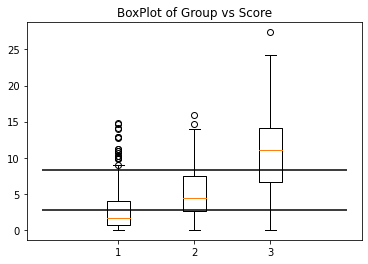

In [ ]:
import random
from sklearn.metrics import f1_score
## We represent confidence as a single matrix. 
## It has n rows, one for each annotator, and two columns, one for the confidence of predicting 0, another for the confidence of predicting 1.
## We initialize our confidence in the predictions of all annotators of 0 or 1 at 1.

confidence = np.ones((len(anns), 2)) 

## Count is accumulated repeatedly. This is an Expectation Step.
## This is a normalized weighted vote.
plt.figure()

frames = []
power = 1
for em_step in range(em_steps):

  count = len(anns) * (np.matmul(doc_anns, np.power(confidence[:, 1],power)) / (np.matmul(doc_anns, np.power(confidence[:, 1], power)) + np.matmul(1 - doc_anns, np.power(confidence[:, 0], power))))

  ## Now, we cluster
  centroids = random.sample(set(count), 3)
  print("Init Centroids: ", centroids)

  alloc = [0 for i in range(len(count))]

  groups = dict()

  for i in range(kmed_steps):

    centroids = sorted(centroids)

    ##Pick the ideal allocation by centroids
    ##alloc should be the elements of centroids that each element of count is closest to.
    
    for c in range(len(count)):

      alloc[c] = np.argmin([(count[c] - centroid)**2 for centroid in centroids])

    ##Pick the ideal centroids, will be the median of the counts per allocs.

    for centroid_index in range(len(centroids)): #(For each centroid, collect all its assignees, then compute their median as the centroid)
      assignees = np.where(np.array(alloc) == centroid_index)[0]
      centroids[centroid_index] = np.median(np.array([count[assignee] for assignee in assignees]))
      groups[centroid_index] =  list(assignees)
      try:
        assert len(assignees) != 0
      except:
        print((centroid_index, centroids[centroid_index]))
        for cent in range(centroid_index):
          print(cent, ":", groups[cent])

  ##Maximization Step:

  lum = set(groups[0]) | set(groups[1])
  muh = set(groups[1]) | set(groups[2])
  assert len(lum) + len(muh) >= len(graded_docs)
  confidence[:, 0] = np.sum(1 - np.array([doc_anns[j, :] for j in lum]), axis = 0)/np.sum(1 - doc_anns, axis = 0)
  confidence[:, 1] = np.sum(np.array([doc_anns[j, :] for j in muh]), axis = 0)/np.sum(doc_anns, axis = 0)

  confidence = np.multiply(confidence, confidence >= 0.5)

  low = [i for i in range(len(graded_docs)) if grades[i] == 0]
  hi = [i for i in range(len(graded_docs)) if grades[i] == 2]
  mid = [i for i in range(len(graded_docs)) if grades[i] == 1]
  #plt.hlines(1, 1, 100)  # Draw a horizontal line

  low_counts = [count[i] for i in low]
  mid_counts = [count[i] for i in mid]
  hi_counts = [count[i] for i in hi]

  centroid_boundaries = [(centroids[0] + centroids[1])/2, (centroids[1] + centroids[2])/2]

  fig1, ax1 = plt.subplots()
  ax1.set_title('BoxPlot of Group vs Score')
  print("Centroids: ", centroids)
  print("Centroid Boundaries: ", centroid_boundaries)
  ax1.boxplot(np.array([low_counts, mid_counts, hi_counts], dtype = object).T)
  
  ax1.hlines(centroid_boundaries[0], 0, 4)  # Draw a horizontal line
  ax1.hlines(centroid_boundaries[1], 0, 4)  # Draw a horizontal line

  print("\nTruly NOT RELEVANT:")
  not_rel_zero = len([1 for count_index in low if count_index in groups[0]])
  not_rel_one = len([1 for count_index in low if count_index in groups[1]])
  not_rel_two = len([1 for count_index in low if count_index in groups[2]])
  not_rel = len(low)
  print("Predicted NOT RELEVANT: ", not_rel_zero, ", Percent: ", 100 * not_rel_zero/not_rel)
  print("Predicted RELEVANT: ", not_rel_one, ", Percent: ", 100 * not_rel_one/not_rel)
  print("Predicted REQUIRED: ", not_rel_two, ", Percent: ", 100 * not_rel_two/not_rel)
  print("Total number of truly NOT RELEVANT: ", not_rel)

  print("\nTruly RELEVANT:")
  rel_zero = len([1 for count_index in mid if count_index in groups[0]])
  rel_one = len([1 for count_index in mid if count_index in groups[1]])
  rel_two = len([1 for count_index in mid if count_index in groups[2]])
  rel = len(mid)
  print("Predicted NOT RELEVANT: ", rel_zero, ", Percent: ", 100 * rel_zero/rel)
  print("Predicted RELEVANT: ", rel_one, ", Percent: ", 100 * rel_one/rel)
  print("Predicted REQUIRED: ", rel_two, ", Percent: ", 100 * rel_two/rel)
  print("Total number of truly RELEVANT: ", rel)

  print("\nTruly REQUIRED:")
  req_zero = len([1 for count_index in hi if count_index in groups[0]])
  req_one = len([1 for count_index in hi if count_index in groups[1]])
  req_two = len([1 for count_index in hi if count_index in groups[2]])
  req = len(hi)
  print("Predicted NOT RELEVANT: ", req_zero, ", Percent: ", 100 * req_zero/req)
  print("Predicted RELEVANT: ", req_one, ", Percent: ", 100 * req_one/req)
  print("Predicted REQUIRED: ", req_two, ", Percent: ", 100 * req_two/req)
  print("Total number of truly REQUIRED: ", req)
  
  ##Class Non-Relevant:
  ##Precision: TP/(TP + FP)
  try:
    non_rel_prec = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(groups[0])
    ##Recall: TP/(TP + FN)
    non_rel_recall = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(low)
    non_rel_f1 = (2 * non_rel_prec * non_rel_recall)/(non_rel_prec + non_rel_recall)

    ##Class Required:
    ##Precision: TP/(TP + FP)
    req_prec = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(groups[2])
    ##Recall: TP/(TP + FN)
    req_recall = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(hi)
    req_f1 = (2 * req_prec * req_recall)/(req_prec + req_recall)
    print("Macro F1: ", (req_f1 + non_rel_f1)/2)
    predicted_grades = []
    predicted_grades_2 = []
    for i in range(len(count)):
      icount = count[i]
      mid_centroid = centroids[1]
      avg_centroid = (centroids[0] + centroids[2])/2
      if(icount <= mid_centroid):
        predicted_grades.append(0)
      elif(icount > mid_centroid):
        predicted_grades.append(1)
      if(icount <= avg_centroid):
        predicted_grades_2.append(0)
      elif(icount > avg_centroid):
        predicted_grades_2.append(1)

    grades = np.array(grades)
    test = grades != 1
    pred_grad = np.array(predicted_grades)
    pred_grad_2 = np.array(predicted_grades_2)
    bin_grad = grades.copy()
    bin_grad[grades >= 1] = 1 
    print("True Macro F1 (Middle-Centroid): ", f1_score(bin_grad[test], pred_grad[test], average = "macro"))
    print("True Macro F1 (Average-Centroid): ", f1_score(bin_grad[test], pred_grad_2[test], average = "macro"))
    plt.show()

  except:
    print("Some group was empty")
for c in range(len(count)):
  alloc[c] = centroids[alloc[c]]

Init Centroids:  [2.5757569928156157, 5.053706494598791, 3.0281428254205376]
Centroids:  [0.47103275851469356, 2.836149326826039, 8.504924953887883]
Centroid Boundaries:  [1.6535910426703662, 5.670537140356961]

Truly NOT RELEVANT:
Predicted NOT RELEVANT:  359 , Percent:  66.35859519408503
Predicted RELEVANT:  163 , Percent:  30.129390018484287
Predicted REQUIRED:  19 , Percent:  3.512014787430684
Total number of truly NOT RELEVANT:  541

Truly RELEVANT:
Predicted NOT RELEVANT:  28 , Percent:  27.184466019417474
Predicted RELEVANT:  54 , Percent:  52.42718446601942
Predicted REQUIRED:  21 , Percent:  20.388349514563107
Total number of truly RELEVANT:  103

Truly REQUIRED:
Predicted NOT RELEVANT:  4 , Percent:  10.81081081081081
Predicted RELEVANT:  10 , Percent:  27.027027027027028
Predicted REQUIRED:  23 , Percent:  62.16216216216216
Total number of truly REQUIRED:  37
Macro F1:  0.8900858369098713
True Macro F1 (Middle-Centroid):  0.6427978401323388
True Macro F1 (Average-Centroid): 

<Figure size 432x288 with 0 Axes>

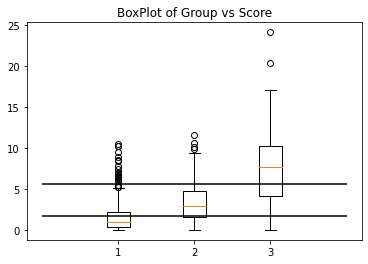

Init Centroids:  [1.3523900092635475, 0.6873154441008743, 0.6660194288354929]
Centroids:  [0.0, 0.7368692648164291, 2.898511382740183]
Centroid Boundaries:  [0.36843463240821456, 1.8176903237783062]

Truly NOT RELEVANT:
Predicted NOT RELEVANT:  377 , Percent:  69.68576709796673
Predicted RELEVANT:  141 , Percent:  26.062846580406653
Predicted REQUIRED:  23 , Percent:  4.251386321626617
Total number of truly NOT RELEVANT:  541

Truly RELEVANT:
Predicted NOT RELEVANT:  33 , Percent:  32.03883495145631
Predicted RELEVANT:  45 , Percent:  43.689320388349515
Predicted REQUIRED:  25 , Percent:  24.271844660194176
Total number of truly RELEVANT:  103

Truly REQUIRED:
Predicted NOT RELEVANT:  5 , Percent:  13.513513513513514
Predicted RELEVANT:  6 , Percent:  16.216216216216218
Predicted REQUIRED:  26 , Percent:  70.27027027027027
Total number of truly REQUIRED:  37
Macro F1:  0.8301292924723888
True Macro F1 (Middle-Centroid):  0.6460958396442267
True Macro F1 (Average-Centroid):  0.743355534

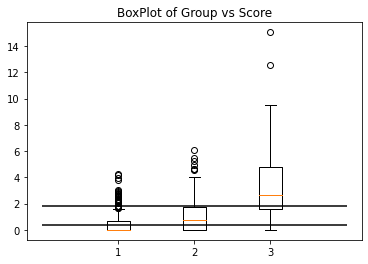

In [ ]:
import random
from sklearn.metrics import f1_score
## We represent confidence as a single matrix. 
## It has n rows, one for each annotator, and two columns, one for the confidence of predicting 0, another for the confidence of predicting 1.
## We initialize our confidence in the predictions of all annotators of 0 or 1 at 1.

confidence = true_conf

## Count is accumulated repeatedly. This is an Expectation Step.
## This is a normalized weighted vote.
plt.figure()

frames = []
power = 1
for em_step in range(2):

  count = len(anns) * (np.matmul(doc_anns, np.power(confidence[:, 1],power)) / (np.matmul(doc_anns, np.power(confidence[:, 1], power)) + np.matmul(1 - doc_anns, np.power(confidence[:, 0], power))))

  ## Now, we cluster
  centroids = random.sample(set(count), 3)
  print("Init Centroids: ", centroids)

  alloc = [0 for i in range(len(count))]

  groups = dict()

  for i in range(kmed_steps):

    centroids = sorted(centroids)

    ##Pick the ideal allocation by centroids
    ##alloc should be the elements of centroids that each element of count is closest to.
    
    for c in range(len(count)):

      alloc[c] = np.argmin([(count[c] - centroid)**2 for centroid in centroids])

    ##Pick the ideal centroids, will be the median of the counts per allocs.

    for centroid_index in range(len(centroids)): #(For each centroid, collect all its assignees, then compute their median as the centroid)
      assignees = np.where(np.array(alloc) == centroid_index)[0]
      centroids[centroid_index] = np.median(np.array([count[assignee] for assignee in assignees]))
      groups[centroid_index] =  list(assignees)
      try:
        assert len(assignees) != 0
      except:
        print((centroid_index, centroids[centroid_index]))
        for cent in range(centroid_index):
          print(cent, ":", groups[cent])

  ##Maximization Step:

  lum = set(groups[0]) | set(groups[1])
  muh = set(groups[1]) | set(groups[2])
  assert len(lum) + len(muh) >= len(graded_docs)
  #confidence[:, 0] = np.sum(1 - np.array([doc_anns[j, :] for j in lum]), axis = 0)/np.sum(1 - doc_anns, axis = 0)
  #confidence[:, 1] = np.sum(np.array([doc_anns[j, :] for j in muh]), axis = 0)/np.sum(doc_anns, axis = 0)

  confidence = np.multiply(confidence, confidence >= 0.5)

  low = [i for i in range(len(graded_docs)) if grades[i] == 0]
  hi = [i for i in range(len(graded_docs)) if grades[i] == 2]
  mid = [i for i in range(len(graded_docs)) if grades[i] == 1]
  #plt.hlines(1, 1, 100)  # Draw a horizontal line

  low_counts = [count[i] for i in low]
  mid_counts = [count[i] for i in mid]
  hi_counts = [count[i] for i in hi]

  centroid_boundaries = [(centroids[0] + centroids[1])/2, (centroids[1] + centroids[2])/2]

  fig1, ax1 = plt.subplots()
  ax1.set_title('BoxPlot of Group vs Score')
  print("Centroids: ", centroids)
  print("Centroid Boundaries: ", centroid_boundaries)
  ax1.boxplot(np.array([low_counts, mid_counts, hi_counts], dtype = object).T)
  
  ax1.hlines(centroid_boundaries[0], 0, 4)  # Draw a horizontal line
  ax1.hlines(centroid_boundaries[1], 0, 4)  # Draw a horizontal line

  print("\nTruly NOT RELEVANT:")
  not_rel_zero = len([1 for count_index in low if count_index in groups[0]])
  not_rel_one = len([1 for count_index in low if count_index in groups[1]])
  not_rel_two = len([1 for count_index in low if count_index in groups[2]])
  not_rel = len(low)
  print("Predicted NOT RELEVANT: ", not_rel_zero, ", Percent: ", 100 * not_rel_zero/not_rel)
  print("Predicted RELEVANT: ", not_rel_one, ", Percent: ", 100 * not_rel_one/not_rel)
  print("Predicted REQUIRED: ", not_rel_two, ", Percent: ", 100 * not_rel_two/not_rel)
  print("Total number of truly NOT RELEVANT: ", not_rel)

  print("\nTruly RELEVANT:")
  rel_zero = len([1 for count_index in mid if count_index in groups[0]])
  rel_one = len([1 for count_index in mid if count_index in groups[1]])
  rel_two = len([1 for count_index in mid if count_index in groups[2]])
  rel = len(mid)
  print("Predicted NOT RELEVANT: ", rel_zero, ", Percent: ", 100 * rel_zero/rel)
  print("Predicted RELEVANT: ", rel_one, ", Percent: ", 100 * rel_one/rel)
  print("Predicted REQUIRED: ", rel_two, ", Percent: ", 100 * rel_two/rel)
  print("Total number of truly RELEVANT: ", rel)

  print("\nTruly REQUIRED:")
  req_zero = len([1 for count_index in hi if count_index in groups[0]])
  req_one = len([1 for count_index in hi if count_index in groups[1]])
  req_two = len([1 for count_index in hi if count_index in groups[2]])
  req = len(hi)
  print("Predicted NOT RELEVANT: ", req_zero, ", Percent: ", 100 * req_zero/req)
  print("Predicted RELEVANT: ", req_one, ", Percent: ", 100 * req_one/req)
  print("Predicted REQUIRED: ", req_two, ", Percent: ", 100 * req_two/req)
  print("Total number of truly REQUIRED: ", req)
  
  ##Class Non-Relevant:
  ##Precision: TP/(TP + FP)
  try:
    non_rel_prec = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(groups[0])
    ##Recall: TP/(TP + FN)
    non_rel_recall = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(low)
    non_rel_f1 = (2 * non_rel_prec * non_rel_recall)/(non_rel_prec + non_rel_recall)

    ##Class Required:
    ##Precision: TP/(TP + FP)
    req_prec = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(groups[2])
    ##Recall: TP/(TP + FN)
    req_recall = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(hi)
    req_f1 = (2 * req_prec * req_recall)/(req_prec + req_recall)
    print("Macro F1: ", (req_f1 + non_rel_f1)/2)
    predicted_grades = []
    predicted_grades_2 = []
    for i in range(len(count)):
      icount = count[i]
      mid_centroid = centroids[1]
      avg_centroid = (centroids[0] + centroids[2])/2
      if(icount <= mid_centroid):
        predicted_grades.append(0)
      elif(icount > mid_centroid):
        predicted_grades.append(1)
      if(icount <= avg_centroid):
        predicted_grades_2.append(0)
      elif(icount > avg_centroid):
        predicted_grades_2.append(1)

    grades = np.array(grades)
    test = grades != 1
    pred_grad = np.array(predicted_grades)
    pred_grad_2 = np.array(predicted_grades_2)
    bin_grad = grades.copy()
    bin_grad[grades >= 1] = 1 
    print("True Macro F1 (Middle-Centroid): ", f1_score(bin_grad[test], pred_grad[test], average = "macro"))
    print("True Macro F1 (Average-Centroid): ", f1_score(bin_grad[test], pred_grad_2[test], average = "macro"))
    plt.show()

  except:
    print("Some group was empty")
for c in range(len(count)):
  alloc[c] = centroids[alloc[c]]

[[1.         0.79261275]
 [0.79261275 1.        ]]


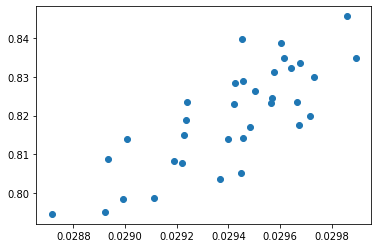

In [ ]:
print(np.corrcoef(confidence[:, 0], true_conf[:, 0]))
plt.scatter(confidence[:, 0], true_conf[:, 0])

[[1.         0.75067206]
 [0.75067206 1.        ]]


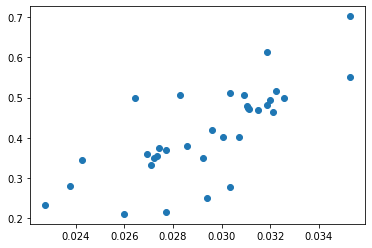

In [ ]:
print(np.corrcoef(confidence[:, 1], true_conf[:, 1]))
plt.scatter(confidence[:, 1], true_conf[:, 1])

In [ ]:
groups[0] = []
groups[1] = []
groups[2] = []
for i in range(len(grades)):
  if(grades[i] == 0):
    groups[0].append(i)
  elif(grades[i] == 1):
    groups[1].append(i)
  elif(grades[i] == 2):
    groups[2].append(i)
    
non_rel_prec = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(groups[0])
##Recall: TP/(TP + FN)
non_rel_recall = len([1 for i in low if i in set(groups[0])|set(groups[1])])/len(low)
non_rel_f1 = (2 * non_rel_prec * non_rel_recall)/(non_rel_prec + non_rel_recall)

##Class Required:
##Precision: TP/(TP + FP)
req_prec = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(groups[2])
##Recall: TP/(TP + FN)
req_recall = len([1 for i in hi if i in set(groups[2])|set(groups[1])])/len(hi)
req_f1 = (2 * req_prec * req_recall)/(req_prec + req_recall)

In [ ]:
req_f1

1.0

In [ ]:
predicted_grades = []
for i in range(len(count)):
  icount = count[i]
  mid_centroid = centroids[1]
  if(icount <= mid_centroid):
    predicted_grades.append(0)
  elif(icount > mid_centroid):
    predicted_grades.append(1)

In [ ]:
predicted_grades[:306]

[1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,


In [ ]:
import matplotlib.pyplot as plt

plt.plot()